- http://localhost:8888/notebooks/data/git/blnd/nbs/DevCropResize0703.ipynb
- https://www.kaggle.com/c/aptos2019-blindness-detection/discussion/98059#latest-566637
- https://www.kaggle.com/tanlikesmath/diabetic-retinopathy-resnet50-binary-cropped

In [9]:
PRFX='DevCropResize0718'
p_o = f'../output/{PRFX}'

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter
from tqdm import tqdm

import pickle

def nfiles(pp):
    return len(list(pp.iterdir()))

def show_sample_images(p):
    fns = np.random.choice(list(p.iterdir()), 5)
    for i, fn in enumerate(fns):
        im = Image.open(str(fn))
        im = np.array(im)
        fig=plt.figure(figsize=(2, 2))
        plt.title(im.shape)
        plt.imshow(im)

In [16]:
Path(p_o).mkdir(exist_ok=True)

# files

In [17]:
p = '../input/aptos2019-blindness-detection'
pp = Path(p)

In [18]:
nfiles(pp/'train_images'), nfiles(pp/'test_images')

(3662, 1928)

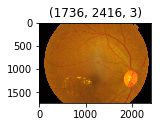

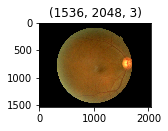

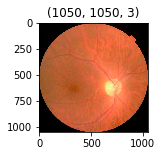

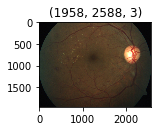

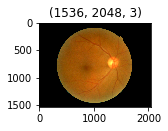

In [19]:
show_sample_images(pp/'train_images')

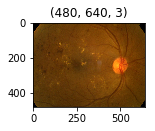

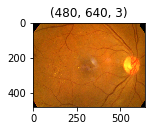

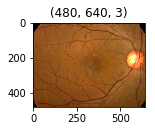

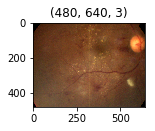

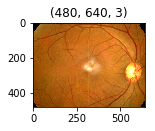

In [23]:
show_sample_images(pp/'test_images')

https://www.kaggle.com/c/aptos2019-blindness-detection/data
You can plan on the private test set consisting of 20GB of data across 13,000 images (approximately).

# get h w stats of images

In [24]:
fnm = list((pp/'train_images').iterdir())[0]
im = Image.open(fnm)
npimg = np.array(im)
h, w, _ = npimg.shape
h, w

(1736, 2416)

In [25]:
def get_hws(fnm):
    im = Image.open(fnm)
    npimg = np.array(im)
    h, w, _ = npimg.shape
    return h,w

In [ ]:
hws_trn=pickle.load(open(f'{p_o}/hws_trn.p', 'rb'))
hws_tst=pickle.load(open(f'{p_o}/hws_tst.p', 'rb'))

# analysis

In [125]:
Counter(hws_trn).most_common()

[((1050, 1050), 974),
 ((1736, 2416), 638),
 ((1958, 2588), 533),
 ((2136, 3216), 410),
 ((1536, 2048), 351),
 ((614, 819), 287),
 ((2588, 3388), 141),
 ((1000, 1504), 92),
 ((1226, 1844), 61),
 ((2848, 4288), 52),
 ((480, 640), 42),
 ((1944, 2896), 34),
 ((1424, 2144), 28),
 ((1117, 1476), 14),
 ((1110, 1467), 2),
 ((358, 474), 2),
 ((1764, 2146), 1)]

In [207]:
[(k,v/len(hws_trn)) for k,v in Counter(hws_trn).most_common()]

[((1050, 1050), 0.2659748771163299),
 ((1736, 2416), 0.1742217367558711),
 ((1958, 2588), 0.14554888039322775),
 ((2136, 3216), 0.1119606772255598),
 ((1536, 2048), 0.09584926269797925),
 ((614, 819), 0.07837247405789186),
 ((2588, 3388), 0.038503549972692515),
 ((1000, 1504), 0.025122883670125613),
 ((1226, 1844), 0.016657564172583288),
 ((2848, 4288), 0.014199890770071),
 ((480, 640), 0.011469142545057346),
 ((1944, 2896), 0.009284543965046422),
 ((1424, 2144), 0.007646095030038231),
 ((1117, 1476), 0.0038230475150191155),
 ((1110, 1467), 0.0005461496450027307),
 ((358, 474), 0.0005461496450027307),
 ((1764, 2146), 0.00027307482250136535)]

In [126]:
Counter(hws_tst).most_common()

[((480, 640), 1403),
 ((1736, 2416), 225),
 ((1958, 2588), 134),
 ((1050, 1050), 69),
 ((614, 819), 45),
 ((1536, 2048), 28),
 ((1944, 2896), 11),
 ((1944, 2592), 6),
 ((1117, 1476), 2),
 ((576, 768), 2),
 ((1110, 1467), 2),
 ((1764, 2146), 1)]

In [208]:
Counter([o[0]/o[1] for o in hws_tst]).most_common()

[(0.75, 1439),
 (0.7185430463576159, 225),
 (0.7565687789799073, 134),
 (1.0, 69),
 (0.7496947496947497, 45),
 (0.6712707182320442, 11),
 (0.7567750677506775, 2),
 (0.7566462167689162, 2),
 (0.8219944082013048, 1)]

In [127]:
[(k,v/len(hws_tst)) for k,v in Counter(hws_tst).most_common()]

[((480, 640), 0.7276970954356846),
 ((1736, 2416), 0.11670124481327801),
 ((1958, 2588), 0.06950207468879668),
 ((1050, 1050), 0.03578838174273859),
 ((614, 819), 0.023340248962655602),
 ((1536, 2048), 0.014522821576763486),
 ((1944, 2896), 0.005705394190871369),
 ((1944, 2592), 0.0031120331950207467),
 ((1117, 1476), 0.001037344398340249),
 ((576, 768), 0.001037344398340249),
 ((1110, 1467), 0.001037344398340249),
 ((1764, 2146), 0.0005186721991701245)]

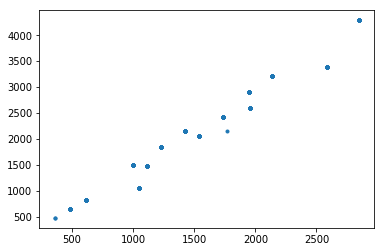

In [128]:
h,w=zip(*hws_trn)

plt.plot(h,w, '.')

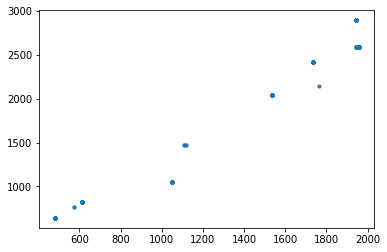

In [129]:
h,w=zip(*hws_tst)

plt.plot(h,w, '.')

# crop

https://www.kaggle.com/tanlikesmath/diabetic-retinopathy-resnet50-binary-cropped/notebook

In [33]:
from fastai.vision import *
import cv2

SZ = 640


# - https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping
# - https://www.kaggle.com/takamichitoda/resnet50-with-ben-graham-s-preprocessing-fast-ai
    
def crop_image(img,tol=7):        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
def open_ben_color(fn, convert_mode, after_open)->Image:
    image = cv2.imread(fn)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (SZ, SZ))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX=10) ,-4 ,128)
    return Image(pil2tensor(image, np.float32).div_(255))

vision.data.open_image = open_ben_color

In [40]:
fnm = np.random.choice(list((pp/'train_images').iterdir()))

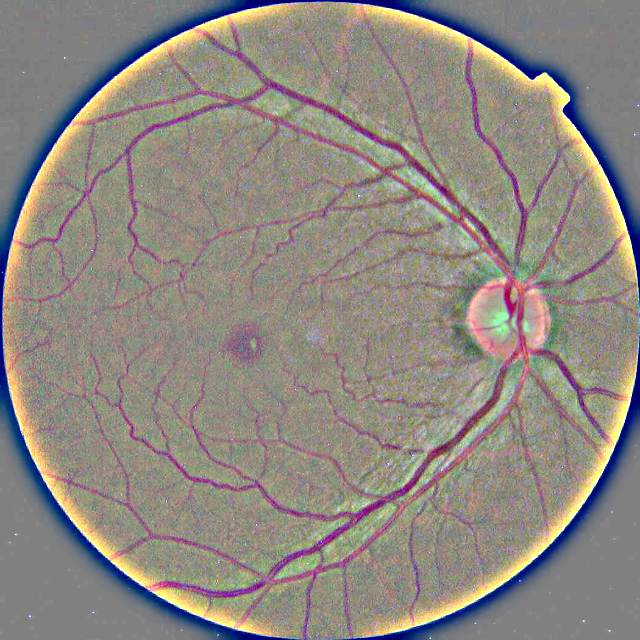

In [41]:
open_ben_color(str(fnm),None,None)

In [44]:
fnm = np.random.choice(list((pp/'test_images').iterdir()))

open_ben_color(str(fnm),None,None)

# old

In [247]:
# import the necessary packages
import numpy as np
import cv2
import glob
import os
from tqdm import tqdm
import math
from PIL import Image


new_sz = 1024

def crop_image(image):
    output = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,gray = cv2.threshold(gray,10,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print('no contours!')
        flag = 0
        return image, flag
    cnt = max(contours, key=cv2.contourArea)
    ((x, y), r) = cv2.minEnclosingCircle(cnt)
    r = r*0.83
    x = int(x); y = int(y); r = int(r)
    flag = 1
    #print(x,y,r)
    if r > 100:
        return output[0 + (y-r)*int(r<y):-1 + (y+r+1)*int(r<y),0 + (x-r)*int(r<x):-1 + (x+r+1)*int(r<x)], flag
    else:
        print('none!')
        flag = 0
        return image,flag

In [252]:
fnm = list((pp/'train_images').iterdir())[900]

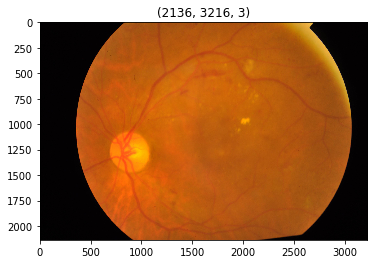

In [253]:
im = Image.open(str(fnm))
im = np.array(im)
plt.title(im.shape)
plt.imshow(im)

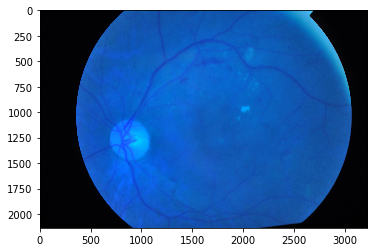

In [257]:
img = cv2.imread(str(fnm))
plt.imshow(img)

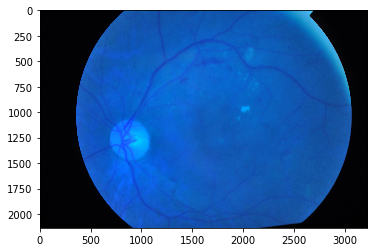

In [280]:
img_cropped, flag = crop_image(img)

plt.imshow(img)

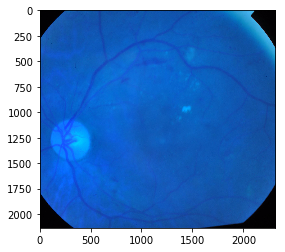

In [281]:
plt.imshow(img_cropped)

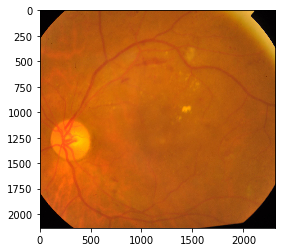

In [273]:
img_cropped = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2RGB)
plt.imshow(img_cropped)

In [274]:
h0, w0 = 480, 640 #most common in test
ratio = h0/w0 #most common in test
height, width, _= img_cropped.shape
print('height, width:', height, width)

w_new, h_new = width, math.ceil(width*ratio)

print('h_new, w_new', h_new, w_new)

height, width: 2135 2308
h_new, w_new 1731 2308


In [275]:
# https://stackoverflow.com/questions/16646183/crop-an-image-in-the-centre-using-pil
def center_crop(img, new_width=None, new_height=None):        

    width = img.shape[1]
    height = img.shape[0]

    if new_width is None:
        new_width = min(width, height)

    if new_height is None:
        new_height = min(width, height)

    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))

    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))

    if len(img.shape) == 2:
        center_cropped_img = img[top:bottom, left:right]
    else:
        center_cropped_img = img[top:bottom, left:right, ...]

    return center_cropped_img


In [278]:
img_cropped_center = center_crop(img_cropped, new_width=w_new, new_height=h_new)

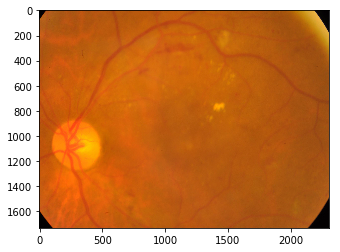

In [279]:
plt.imshow(img_cropped_center)

# put together

In [282]:
def crop_image(image, keep_less=0.83):
    output = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,gray = cv2.threshold(gray,10,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        #print('no contours!')
        flag = 0
        return image, flag
    cnt = max(contours, key=cv2.contourArea)
    ((x, y), r) = cv2.minEnclosingCircle(cnt)
    r = r*keep_less
    x = int(x); y = int(y); r = int(r)
    flag = 1
    #print(x,y,r)
    if r > 100:
        return output[0 + (y-r)*int(r<y):-1 + (y+r+1)*int(r<y),0 + (x-r)*int(r<x):-1 + (x+r+1)*int(r<x)], flag
    else:
        #print('none!')
        flag = 0
        return image,flag

In [283]:
# https://stackoverflow.com/questions/16646183/crop-an-image-in-the-centre-using-pil
def center_crop(img, new_width=None, new_height=None):        

    width = img.shape[1]
    height = img.shape[0]

    if new_width is None:
        new_width = min(width, height)

    if new_height is None:
        new_height = min(width, height)

    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))

    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))

    if len(img.shape) == 2:
        center_cropped_img = img[top:bottom, left:right]
    else:
        center_cropped_img = img[top:bottom, left:right, ...]

    return center_cropped_img

In [284]:
def process_fnm(fnm):
    fnm = str(fnm)
    h0, w0 = 480, 640 #most common in test
    ratio = h0/w0 #most common in test
    img = cv2.imread(fnm)
    
    img_cropped, flag = crop_image(img)
    img_cropped = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2RGB)

        
    height, width, _= img_cropped.shape
    w_new, h_new = width, math.ceil(width*ratio)
    
    img_cropped_center = center_crop(img_cropped, new_width=w_new, new_height=h_new)
    
    fnm_new = fnm.replace('../input', p_o)
    Image.fromarray(img_cropped_center).save(fnm_new)

In [285]:
Path(f'{p_o}/aptos2019-blindness-detection/train_images/').mkdir(exist_ok=True, parents=True)

In [286]:
process_fnm(fnm)

In [287]:
ls $p_o/aptos2019-blindness-detection/train_images/

d91273efb92a.png


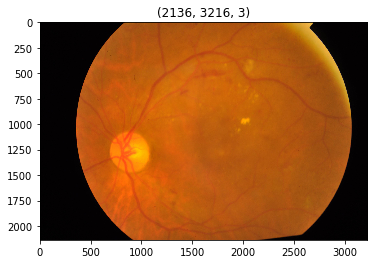

In [288]:
im = Image.open(str(fnm))
im = np.array(im)
plt.title(im.shape)
plt.imshow(im)

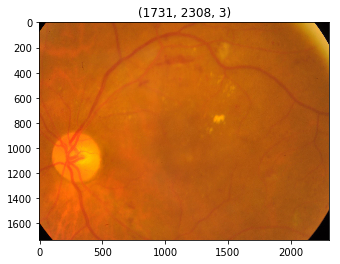

In [289]:
im = Image.open(str(fnm).replace('../input', p_o))
im = np.array(im)
plt.title(im.shape)
plt.imshow(im)

# parallel

In [285]:
Path(f'{p_o}/aptos2019-blindness-detection/train_images/').mkdir(exist_ok=True, parents=True)

In [293]:
Path(f'{p_o}/aptos2019-blindness-detection/test_images/').mkdir(exist_ok=True, parents=True)

https://www.kaggle.com/c/diabetic-retinopathy-detection/discussion/12803#latest-66496

In [ ]:
import os
import glob
from joblib import Parallel, delayed


fnms = list((pp/'train_images').iterdir())[:10] + list((pp/'test_images').iterdir())[:10]

In [299]:
%%time
Parallel(n_jobs=8, verbose=10)(delayed(process_fnm)(fnm) for fnm in fnms)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:    1.8s remaining:    2.7s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:    2.0s remaining:    1.6s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:    2.2s remaining:    0.9s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:    2.7s remaining:    0.5s


CPU times: user 161 ms, sys: 10.4 ms, total: 171 ms
Wall time: 6.78 s


[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    4.0s finished


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [300]:
!ls -hl $p_o/*/*/*.png

-rw-r--r-- 1 root root 221K Jul  3 14:47 ../output/DevCropResize0703/aptos2019-blindness-detection/test_images/01499815e469.png
-rw-r--r-- 1 root root 210K Jul  3 14:47 ../output/DevCropResize0703/aptos2019-blindness-detection/test_images/03042a663e54.png
-rw-r--r-- 1 root root 1.4M Jul  3 14:47 ../output/DevCropResize0703/aptos2019-blindness-detection/test_images/464ee4a542b0.png
-rw-r--r-- 1 root root 221K Jul  3 14:47 ../output/DevCropResize0703/aptos2019-blindness-detection/test_images/7007d3ba7e79.png
-rw-r--r-- 1 root root 221K Jul  3 14:47 ../output/DevCropResize0703/aptos2019-blindness-detection/test_images/75c6563ed058.png
-rw-r--r-- 1 root root 213K Jul  3 14:47 ../output/DevCropResize0703/aptos2019-blindness-detection/test_images/8bdd3a1895c8.png
-rw-r--r-- 1 root root 660K Jul  3 14:47 ../output/DevCropResize0703/aptos2019-blindness-detection/test_images/95c3558dc279.png
-rw-r--r-- 1 root root 216K Jul  3 14:47 ../output/DevCropResize0703/aptos2019-blindness-detection/test_

# see results

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


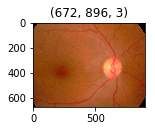

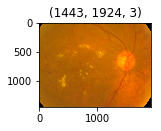

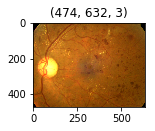

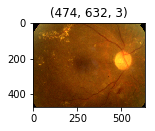

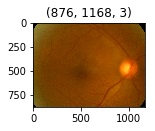

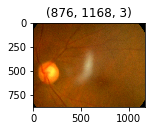

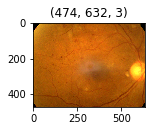

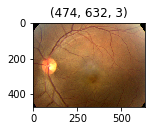

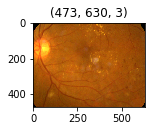

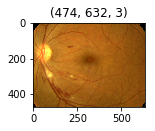

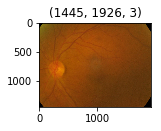

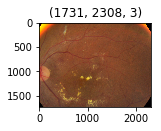

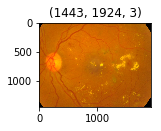

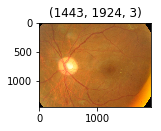

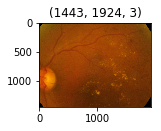

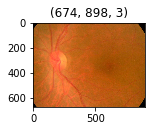

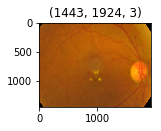

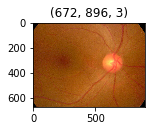

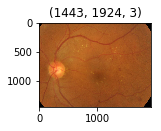

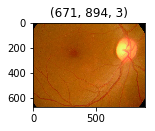

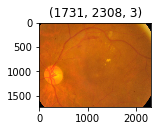

In [311]:
for fnm in glob.glob(f'{p_o}/*/*/*.png'):
    fig=plt.figure(figsize=(2, 2))
    im = Image.open(str(fnm))
    im = np.array(im)
    plt.title(im.shape)
    plt.imshow(im)